In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import PIL.Image as Image
import pandas as pd
import random

import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torchsummary import summary
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Prepare the dataset

In [ ]:
!gdown --id 13Q-n32Bkf8-njeTkV2c-MaWb5S0byowq
!mkdir atml-assignment-3
!unzip atml-assignment-3-data.zip -d atml-assignment-3

In [ ]:
class LabeledDataset(Dataset):
    def __init__(self, folder_path, phase='train', transform=None):
        super(LabeledDataset, self).__init__()
        self.phase = phase
        if self.phase == 'train':
            file_path = os.path.join(folder_path, 'train_32x32_500_label.npz')
        elif self.phase == 'val':
            file_path = os.path.join(folder_path, 'test_32x32_2000_label.npz')
        elif self.phase == 'test':
            file_path = os.path.join(folder_path, 'test_32x32_competition.npy')
        elif self.phase == 'unlabel':
            file_path = os.path.join(folder_path, 'train_32x32_unlabel.npy')
        else:
            print('Unrecognized phase')
        data_load = np.load(file_path)
        
        if self.phase != 'test':
            self.dataset = data_load['img']
            self.labels = data_load['label'].astype('int64')
        else:
            self.dataset = data_load
            
        self.transform = transform
        
    def __getitem__(self, index): 
        img_index = Image.fromarray(self.dataset[index,:])
        if self.phase != 'test':
            return self.transform(img_index), self.labels[index,0]
        else:
            return self.transform(img_index)

    def __len__(self):
        return self.dataset.shape[0]

In [ ]:
transform = transforms.Compose([
                                transforms.ColorJitter(0.2,0.4,0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train_set = LabeledDataset('./atml-assignment-3', phase='train', transform=transform)
val_set   = LabeledDataset('./atml-assignment-3', phase='val',   transform=transform)
test_set  = LabeledDataset('./atml-assignment-3', phase='test',  transform=transform)
unlabel_set = LabeledDataset('./atml-assignment-3', phase='unlabel', transform=transform)


batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)
unlabel_loader = DataLoader(unlabel_set, batch_size=batch_size, shuffle=True,  num_workers=2)

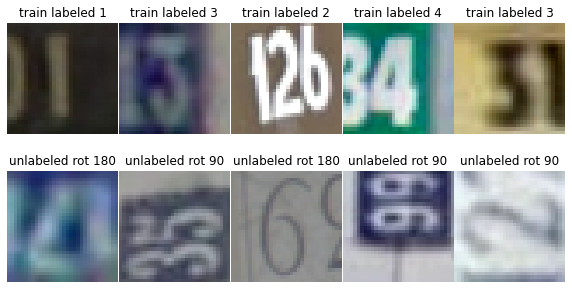

In [ ]:
# Show some examples
fig, axes = plt.subplots(2, 5, figsize=(10,5))
axes = [ax for axs in axes for ax in axs]

for j in range(5):
    idx = np.random.randint(0, len(train_set))
    axes[j].imshow(train_set[idx][0].permute(1,2,0)*0.5+0.5)
    axes[j].axis('off')
    axes[j].set_title('train labeled {}'.format(train_set[idx][1]))

    idx = np.random.randint(0, len(unlabel_set))
    img, label = unlabel_set[idx]
    axes[j+5].imshow(img.permute(1,2,0)*0.5+0.5)
    axes[j+5].axis('off')
    axes[j+5].set_title('unlabeled rot {}'.format(label*90))
plt.subplots_adjust(wspace=0.01)

# Define the GAN architecture



**Unsupervised learning by training DCGAN Model**

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=128, ngf=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.ngf = ngf

        self.deconv1 = nn.Sequential( # output = (B, 128, 4, 4)
            nn.ConvTranspose2d(z_dim, ngf * 4, (4, 4), bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True)
        )
        self.deconv2 = nn.Sequential( #output = (B, 64, 8, 8)
            nn.ConvTranspose2d(ngf * 4, ngf * 2, (4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True)
        )
        self.deconv3 = nn.Sequential( #output = (B, 32, 16, 16)
            nn.ConvTranspose2d(ngf * 2, ngf, (4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True)
        )
        self.deconv4 = nn.Sequential( #output = (B, 3, 32, 32)
            nn.ConvTranspose2d(ngf, 3, (4, 4), stride=2, padding=1, bias=False)
        )

    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = torch.tanh(self.deconv4(x))
        return x

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, ndf=64):
        super(Discriminator, self).__init__()
        self.ndf = ndf

        self.conv1 = nn.Sequential( # output = (B, 64, 16, 16) 
            nn.Conv2d(3, ndf, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf), #0.8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )
        self.conv2 = nn.Sequential( # output = (B, 128, 8, 8)
            nn.Conv2d(ndf, ndf * 2, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )
        self.conv3 = nn.Sequential( # output = (B, 256, 4, 4)
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )
        self.discriminator_head = nn.Sequential( # output = (B, 1, 1, 1)
            nn.Conv2d(ndf * 4, 1, kernel_size=(4, 4), stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.discriminator_head(output)
        return output.squeeze(3).squeeze(2).squeeze(1)

In [ ]:
cuda_available = torch.cuda.is_available()

generator = Generator()
discriminator = Discriminator()
if cuda_available:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

loss = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

In [ ]:
ctr = 0
z_dim = 128

minibatch_disc_losses = []
minibatch_gen_losses = []

for epoch in range(20):
    losses = []
    for batch_idx, (inputs, _) in enumerate(unlabel_loader):
        ctr += 1
        if cuda_available:
            inputs = inputs.cuda()
        inputs = Variable(inputs.cuda())
        
        zeros = Variable(torch.zeros(inputs.size(0)))
        ones  = Variable(torch.ones(inputs.size(0)))
        if cuda_available:
            zeros, ones = zeros.cuda(), ones.cuda()

        # (1) Update Discriminator
        # Sample z ~ N(0, 1)
        minibatch_noise = Variable(torch.from_numpy(
            np.random.randn(inputs.size(0), z_dim, 1, 1).astype(np.float32)))
        if cuda_available:
            minibatch_noise = minibatch_noise.cuda()
        
        # Zero gradients for the discriminator
        optimizer_d.zero_grad()
        
        # Train with real examples
        d_real = discriminator(inputs)
        d_real_loss = loss(d_real, ones) 
        d_real_loss.backward()

        # Train with fake examples from the generator
        fake = generator(minibatch_noise).detach()  

        d_fake = discriminator(fake)
        d_fake_loss = loss(d_fake, zeros)  
        d_fake_loss.backward()

        minibatch_disc_losses.append(d_real_loss.item() + d_fake_loss.item())
        
        # Update the discriminator
        optimizer_d.step()


        # (2) Update Generator
        # Zero gradients for the generator
        optimizer_g.zero_grad()
        
        # Sample z ~ N(0, 1)
        minibatch_noise = Variable(torch.from_numpy(
            np.random.randn(inputs.size(0), z_dim, 1, 1).astype(np.float32)))
        if cuda_available:
            minibatch_noise = minibatch_noise.cuda()

        d_fake = discriminator(generator(minibatch_noise))
        g_loss = loss(d_fake, ones) 
        g_loss.backward()

        # Update the generator
        optimizer_g.step()
        minibatch_gen_losses.append(g_loss.item())
    
    print('Generator loss : %.3f' % (np.mean(minibatch_gen_losses)))
    print('Discriminator loss : %.3f' % (np.mean(minibatch_disc_losses)))

Generator loss : 10.186
Discriminator loss : 0.178
Generator loss : 7.310
Discriminator loss : 0.338
Generator loss : 6.404
Discriminator loss : 0.390
Generator loss : 5.563
Discriminator loss : 0.474
Generator loss : 5.138
Discriminator loss : 0.497
Generator loss : 4.760
Discriminator loss : 0.535
Generator loss : 4.392
Discriminator loss : 0.588
Generator loss : 4.070
Discriminator loss : 0.639
Generator loss : 3.819
Discriminator loss : 0.675
Generator loss : 3.614
Discriminator loss : 0.704
Generator loss : 3.448
Discriminator loss : 0.728
Generator loss : 3.309
Discriminator loss : 0.746
Generator loss : 3.196
Discriminator loss : 0.760
Generator loss : 3.095
Discriminator loss : 0.773
Generator loss : 3.004
Discriminator loss : 0.787
Generator loss : 2.921
Discriminator loss : 0.800
Generator loss : 2.847
Discriminator loss : 0.810
Generator loss : 2.782
Discriminator loss : 0.820
Generator loss : 2.722
Discriminator loss : 0.829
Generator loss : 2.668
Discriminator loss : 0.837

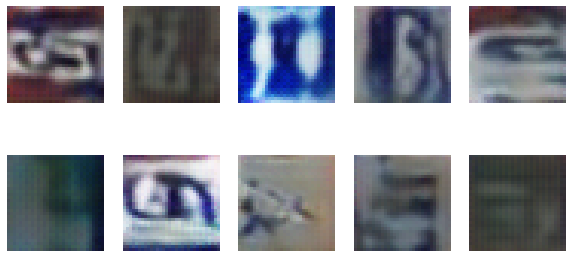

In [ ]:
# Set generator in evaluation mode to use running means and averages for Batchnorm
generator.eval()

# Sample z ~ N(0, 1)
minibatch_noise = Variable(torch.from_numpy(np.random.randn(32, z_dim, 1, 1).astype(np.float32)))
if cuda_available:
    minibatch_noise = minibatch_noise.cuda()

fakes = generator(minibatch_noise)

fig = plt.figure(figsize=(10, 5))
for ind, fake in enumerate(fakes[:10]):
    fig.add_subplot(2, 5, ind+1)
    plt.imshow(fakes[ind].detach().permute(1,2,0).cpu().numpy()*0.5+0.5)
    plt.axis('off')

# Transfer learning 

### Fixed features

In [ ]:
# extract features
features = nn.Sequential(*(list(discriminator.children())[:4]))

# freeze all model parameters
for param in features.parameters():
    param.requires_grad = False

# new final layer with 10 classes
discriminator.discriminator_head = nn.Conv2d(256, 10, 4, 1, 0).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

train_model(discriminator, train_loader, criterion, optimizer, epochs=20)

evaluate(discriminator, val_loader, criterion)

Epoch  1. Accuracy: 35.200 %. And loss: 1.925
Epoch  2. Accuracy: 66.400 %. And loss: 1.233
Epoch  3. Accuracy: 80.400 %. And loss: 0.911
Epoch  4. Accuracy: 82.600 %. And loss: 0.756
Epoch  5. Accuracy: 87.000 %. And loss: 0.657
Epoch  6. Accuracy: 88.600 %. And loss: 0.607
Epoch  7. Accuracy: 90.800 %. And loss: 0.510
Epoch  8. Accuracy: 90.400 %. And loss: 0.478
Epoch  9. Accuracy: 93.800 %. And loss: 0.420
Epoch 10. Accuracy: 93.200 %. And loss: 0.388
Epoch 11. Accuracy: 94.200 %. And loss: 0.375
Epoch 12. Accuracy: 93.600 %. And loss: 0.352
Epoch 13. Accuracy: 93.200 %. And loss: 0.363
Epoch 14. Accuracy: 94.600 %. And loss: 0.319
Epoch 15. Accuracy: 94.400 %. And loss: 0.332
Epoch 16. Accuracy: 96.400 %. And loss: 0.274
Epoch 17. Accuracy: 95.400 %. And loss: 0.288
Epoch 18. Accuracy: 96.400 %. And loss: 0.255
Epoch 19. Accuracy: 96.200 %. And loss: 0.249
Epoch 20. Accuracy: 95.600 %. And loss: 0.246
Accuracy of the network on the 2000 validation images: 62.100 %
Val loss 1.27970

(1.2797002385533045, 62.1)

### Finetuned features

In [ ]:
# extract features
features = nn.Sequential(*(list(discriminator.children())[:4]))

# freeze all model parameters
for param in features.parameters():
    param.requires_grad = True

# new final layer with 10 classes
discriminator.discriminator_head = nn.Conv2d(256, 10, 4, 1, 0).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

train_model(discriminator, train_loader, criterion, optimizer, epochs=20)

evaluate(discriminator, val_loader, criterion)

Epoch  1. Accuracy: 34.800 %. And loss: 1.890
Epoch  2. Accuracy: 69.800 %. And loss: 1.183
Epoch  3. Accuracy: 79.600 %. And loss: 0.862
Epoch  4. Accuracy: 86.800 %. And loss: 0.676
Epoch  5. Accuracy: 86.000 %. And loss: 0.583
Epoch  6. Accuracy: 89.400 %. And loss: 0.507
Epoch  7. Accuracy: 92.400 %. And loss: 0.415
Epoch  8. Accuracy: 93.200 %. And loss: 0.356
Epoch  9. Accuracy: 93.800 %. And loss: 0.299
Epoch 10. Accuracy: 94.200 %. And loss: 0.302
Epoch 11. Accuracy: 96.200 %. And loss: 0.257
Epoch 12. Accuracy: 96.200 %. And loss: 0.226
Epoch 13. Accuracy: 96.000 %. And loss: 0.212
Epoch 14. Accuracy: 96.600 %. And loss: 0.185
Epoch 15. Accuracy: 96.600 %. And loss: 0.169
Epoch 16. Accuracy: 96.600 %. And loss: 0.162
Epoch 17. Accuracy: 97.600 %. And loss: 0.133
Epoch 18. Accuracy: 98.600 %. And loss: 0.116
Epoch 19. Accuracy: 98.600 %. And loss: 0.122
Epoch 20. Accuracy: 98.200 %. And loss: 0.096
Accuracy of the network on the 2000 validation images: 62.800 %
Val loss 1.37574

(1.3757436445781164, 62.8)